##Pre-Process

In [1]:
!pip install librosa
import os
import tqdm
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# Define paths and parameters
DATASET_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [3]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

In [4]:
for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

##Train Model

In [5]:
X = np.array(X)
y = np.array(y)

(array([[[-77.99522 , -80.      , -80.      , ..., -80.      ,
          -80.      , -78.569336],
         [-70.49184 , -76.31891 , -80.      , ..., -80.      ,
          -80.      , -76.42357 ],
         [-59.41279 , -59.225166, -62.864876, ..., -64.179985,
          -64.98839 , -67.191246],
         ...,
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ]],
 
        [[-67.49096 , -73.61943 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-65.48586 , -71.42825 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-61.25968 , -60.12696 , -60.503258, ..., -66.97651 ,
          -61.738617, -61.109505],
         ...,
         [-80.      , -80.      , -80.      , ..., -69.02563 ,
          -69.156944, -7

In [6]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [7]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [8]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)

In [10]:
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [11]:
model = Model(inputs=model_input, outputs=model_output)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the Model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8841 - loss: 1.6608 - val_accuracy: 0.4054 - val_loss: 1.2959
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9789 - loss: 0.0641 - val_accuracy: 0.2951 - val_loss: 4.0037
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9913 - loss: 0.0294 - val_accuracy: 0.2689 - val_loss: 3.5813
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9931 - loss: 0.0217 - val_accuracy: 0.2132 - val_loss: 6.6996
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9953 - loss: 0.0123 - val_accuracy: 0.2634 - val_loss: 5.1629
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9957 - loss: 0.0136 - val_accuracy: 0.2254 - val_loss: 7.3178
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.2539 - val_loss: 7.9995
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9933 - loss: 0.0214 - val_accuracy: 

In [14]:
# saving the model
model.save("audio_classifier.h5")

## Evaluation & Visualisation

In [1]:
import os
import numpy as np
import librosa
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

TEST_DATASET_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac"
MODEL_PATH = "/kaggle/input/audio_classifier/keras/default/1/audio_classifier.h5"  # Replace with the actual path to your saved model
PROTOCOL_FILE_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 109
TEST_FILES_NO = 10000
model = load_model(MODEL_PATH)
# Load and preprocess test data using librosa
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)

def get_valid_filenames_and_labels(protocol_path):
    valid_filenames = set()
    true_labels = {}  # Must be a dictionary, not a set
    with open(protocol_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > 1:
                filename = parts[1]  # Extract filename
                label = 1 if parts[-1] == "bonafide" else 0  # Map 'bonafide' → 1, 'spoof' → 0
                valid_filenames.add(filename)
                true_labels[filename] = label  # Ensure correct mapping
    return valid_filenames, true_labels



valid_filenames, true_labels = get_valid_filenames_and_labels(PROTOCOL_FILE_PATH)

X_test = []
y_true = []



In [2]:
for file_name in test_files:
    if len(X_test) >= TEST_FILES_NO:
        break
    file_name = file_name.removesuffix(".flac")
    if file_name in valid_filenames:
        file_path = os.path.join(TEST_DATASET_PATH, file_name+".flac")

        # Load audio file using librosa
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        # Extract Mel spectrogram using librosa
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Ensure all spectrograms have the same width (time steps)
        if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

        X_test.append((file_name, mel_spectrogram))
        y_true.append(true_labels[file_name])



In [6]:
# Convert list to numpy array
X_test_array = np.array([x[1] for x in X_test])
file_names = [x[0] for x in X_test]
y_true = np.array(y_true)

# Predict using the loaded model
y_pred = model.predict(X_test_array)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print(f"Total valid files tested: {len(X_test)}")
acc = (conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[1][1]+conf_matrix[0][1]+conf_matrix[1][0])
print(f"Accuracy: {acc*100}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total valid files tested: 10000
Accuracy: 80.07


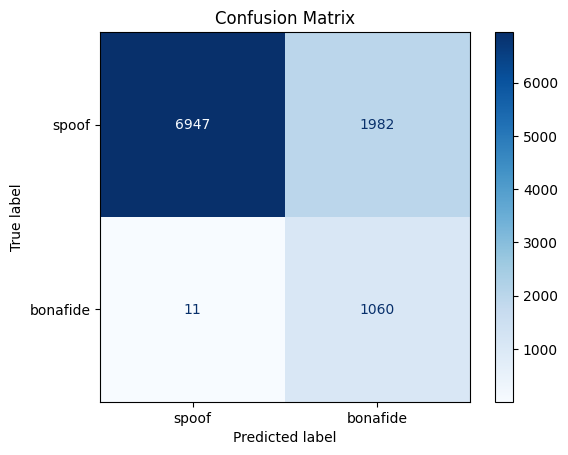

In [7]:
# cm = confusion_matrix(protocol_true_labels[:100], y_pred_classes[:100])
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Display the confusion matrix
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()